![example](images/director_shot.jpeg)

# Microsoft Studios - 3 Keys to Success 

By: Aalok Joshi, Jerry Vasquez, Zach Hanly, TJ Bray

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

In [2]:
# Here you run your code to explore the data

# Box Office Mojo by IMDb Pro
movie_gross_df = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')

# IMDb
imdb_name_df = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
imdb_akas_df = pd.read_csv('data/zippedData/imdb.title.akas.csv.gz')
imdb_basics_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
imdb_crew_df = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
imdb_principals_df = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')

# Rotten Tomatos
rt_movies_df = pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

# The Movie Database
tmdb_movies_df = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')

# The Numbers
tn_budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [3]:
# Here you run your code to clean the data

<br>

Finding the top 20 directos by worldwide gross:
- Begin with a main DatFrame of all movie titles from the US region and drop the extra rows for movies listed more than once.
- Then add the ratings for each movie by joining with the Imdb ratings csv and reduce columns to only the movies unique id, name and average rating.  


Add Directors, their name and the "worldwide gross" for each movie:
- Build another DataFrame from the IMDb priciples csv containing only those in the director category, then attach to main DataFrame using each movies unique id. 
- Then use each directors unique id to add on their name contained in the IMDb name csv.
- Add each movies domestic and foreign gross contaied in the movie gross csv from Box Office Mojo by IMDb Pro and create a worldwide gross column by adding those two columns.

Orgonizing DateFrame by director:
- Drop rows that do not have either a name for the movie director or a value for worldwide gross
- Grouping the movies by director and reducing columns to the average worldwide gross and the average rating

In [4]:
# Here you run your code to clean the data
# finding top 20 directors
titles = imdb_akas_df[imdb_akas_df['region'] == 'US'].drop_duplicates(subset=['title_id'])
add_ratings = titles.join(imdb_ratings_df.set_index('tconst'), on='title_id')
add_ratings = add_ratings[['title_id', 'title', 'averagerating',]]

# add directors names and make worldwid gross column
directors = imdb_principals_df[imdb_principals_df['category'] == 'director']
add_director = add_ratings.join(directors.set_index('tconst'), on='title_id')
add_dir_name = add_director.join(imdb_name_df.set_index('nconst'), on='nconst')
add_gross = add_dir_name.join(movie_gross_df.set_index('title'), on='title')

add_gross['foreign_gross'] = add_gross['foreign_gross'].str.replace(',', '').apply(lambda x: float(x))
add_gross['worldwide_gross'] = add_gross['domestic_gross'] + add_gross['foreign_gross']

# group by director
dropped = add_gross.dropna(subset=['primary_name','worldwide_gross'])
director_df = dropped.groupby('primary_name').mean()
director_df = director_df[['averagerating', 'worldwide_gross']]

In [5]:
# cleaning data from given CSVs
imdb_basics = imdb_basics_df
imdb_basics = imdb_basics.rename(columns = {'primary_title' : 'title'})

# create Profit column
tn_budgets = tn_budgets_df
tn_budgets = tn_budgets.rename(columns = {'movie' : 'title'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['profit'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']

# merge movies with financial data
movie_gross_and_basics = imdb_basics.merge(tn_budgets, how = 'inner', on ='title')
movie_gross_and_basics = movie_gross_and_basics.drop_duplicates(subset = ['title'])

# clean crew data
imdb_name = imdb_name_df
imdb_crew = imdb_crew_df
imdb_crew = imdb_crew.merge(movie_gross_and_basics[['title', 'tconst']], on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_crew = imdb_crew.dropna(subset = ['title'])

#clean ratings data
imdb_ratings = imdb_ratings_df
imdb_ratings = imdb_ratings.merge(movie_gross_and_basics, on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_ratings = imdb_ratings.dropna(subset = ['title']).sort_values('averagerating', ascending = False).drop(columns = ['original_title'], axis = 1)
imdb_ratings['release_date'] = pd.to_datetime(imdb_ratings['release_date'])

#separate writers and create Return on Investment
writers = imdb_crew.assign(writers = lambda x :imdb_crew['writers'].str.split(','))
writers_profit = writers.explode('writers').merge(imdb_ratings, on = 'tconst', how = 'left', validate = 'many_to_one')
writers_profit['ROI'] = writers_profit['profit']/writers_profit['production_budget']*100
writers_profit = writers_profit.dropna(subset = ['ROI'])
writers_profit = writers_profit.merge(imdb_name[['primary_name', 'nconst']], left_on = ['writers'], right_on = 'nconst', how = 'left', validate = 'many_to_one')
writers_profit = writers_profit.merge(imdb_basics[['tconst', 'title']], on = 'tconst', how = 'left', validate = 'many_to_one')

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [6]:
# Here you run your code to model the data


<br>

Find top 20 directors:
- Sort the directors by worldwide gross and limit to the top 20 
- Sort another version of this top 20 DataFrame by rating for graphing later on

Clean for graphing:
- Create a list of each directors name with their average rating
- Store each movies worldwide gross in a seperate variable

Find best directors in the top 20:
- Create top 10 lists for each of the average worldwide gross and average rating columns
- Use intersection method to find the directors that appear in both new top 10 lists

Find the correlation between a directors' average worldwide gross and the average rating of their movies

In [7]:
# Here you run your code to model the data
# Find th etop 20 directors
top20_directors = director_df.sort_values(by='worldwide_gross', ascending=False )[:20]
top20_dir_by_rating = top20_directors.sort_values(by='averagerating')

# clean for graphinig
names = top20_dir_by_rating.index
ratings = top20_dir_by_rating.averagerating.values.round(2)
names_with_rating = [x+': '+str(y) for x,y in zip(names, ratings)]
gross = top20_dir_by_rating.worldwide_gross

# find best directors
top_rated = top20_dir_by_rating[-10:].averagerating.index
top_grossed = top20_directors.worldwide_gross[:10].index
top_directors = top_rated.intersection(top_grossed)

# correlation
corr_per_director = round(top20_directors.corr().iloc[0][1], 2)
corr_per_movie = dropped[['averagerating', 'worldwide_gross']].corr().iloc[0][1].round(2)
print(f'Correlation between worldwide gross and rating per movie: {corr_per_movie}')
print(f'Correlation between average worldwide gross and average rating for the top 20 directors is: {corr_per_director}')

Correlation between worldwide gross and rating per movie: 0.19
Correlation between average worldwide gross and average rating for the top 20 directors is: 0.07


In [43]:
#find top writers based on Return on Investment
top_writers = writers_profit.where(writers_profit['ROI'] > 1).sort_values('ROI', ascending = False)
top_writers_2000 = top_writers[(top_writers['release_date'] > '2000-1-1')]
writers_plot = top_writers_2000.groupby('primary_name').mean('ROI').sort_values('ROI', ascending = False)[:30]
wnames = writers_plot.index
wratings = writers_plot.averagerating.values.round(2)
wnames_wrating = [x+': '+str(y) for x,y in zip(wnames,wratings)]

<br>

Graphing the top 20 directors for worlwide gross, ordered on the Y-axis by average rating. Directors who are top 10 in both categories are labeled in green

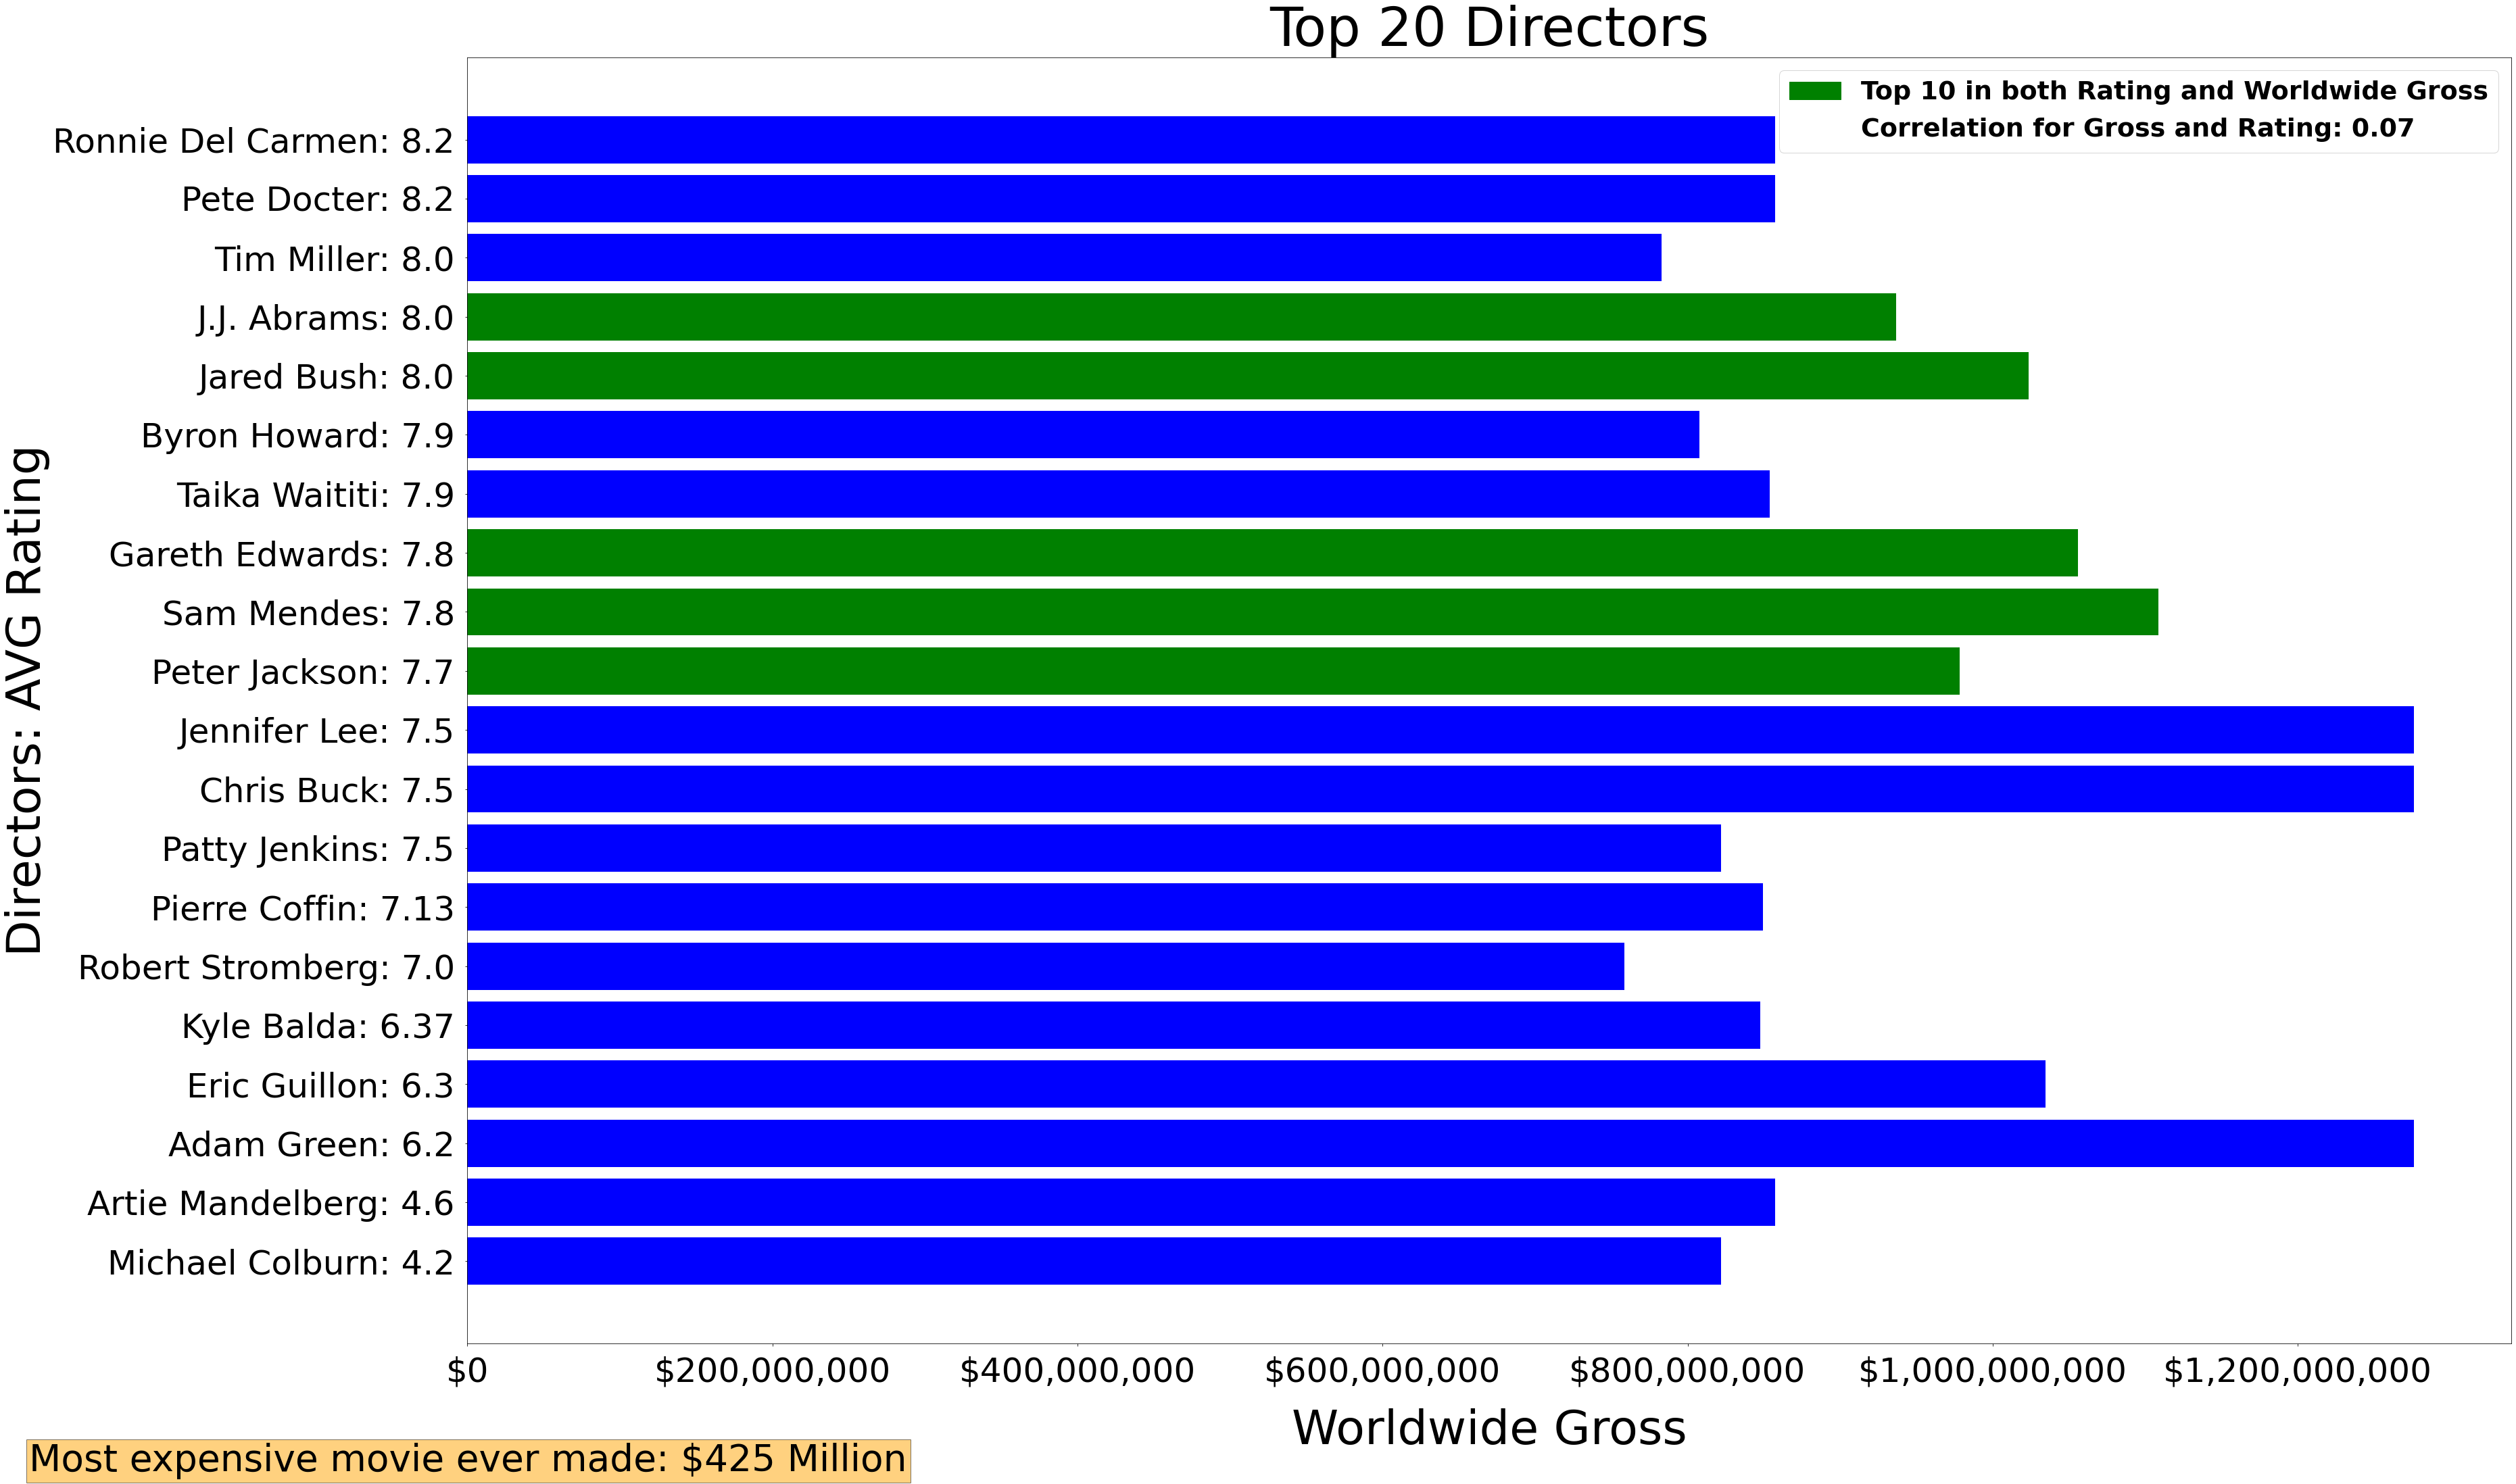

In [9]:
fig, ax = plt.subplots(figsize=(60,35))
plt.subplots_adjust(left=0.2)

# create list of bar color codes
bin_colors = ['b' if x not in top_directors else 'g' for x in top20_dir_by_rating.index]

# Bar chart
ax.barh(names_with_rating, gross, color=bin_colors)
ax.set_title('Top 20 Directors', size=80)

# Y-axis
ax.set_ylabel('Directors: AVG Rating', size=70)
ax.set_yticks(list(range(0,20)))
ax.set_yticklabels(names_with_rating, size=50)

# X-axis
ax.set_xlabel('Worldwide Gross', size=70)
ax.xaxis.labelpad = 30
x_ticks = [0,200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000]
x_lables = ['$0', '$200,000,000', '$400,000,000', '$600,000,000', \
            '$800,000,000', '$1,000,000,000', '$1,200,000,000']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_lables, size=50)
ax.tick_params(axis='both', which='major', pad=15)

# Legend
green_patch = mpatches.Patch(color='green', label='Top 10 in both Rating and Worldwide Gross')
corr_patch = mpatches.Patch(color='None',label=f'Correlation for Gross and Rating: {corr_per_director}')
plt.legend(handles=[green_patch, corr_patch], prop={'size': 38, 'weight': 'bold'}, loc='upper right')

# footnote
bbox_ = {"facecolor":"orange", "alpha":0.5, "pad":5}
plt.figtext(0.05, 0.05, "Most expensive movie ever made: $425 Million", ha="left", fontsize=55, bbox=bbox_);

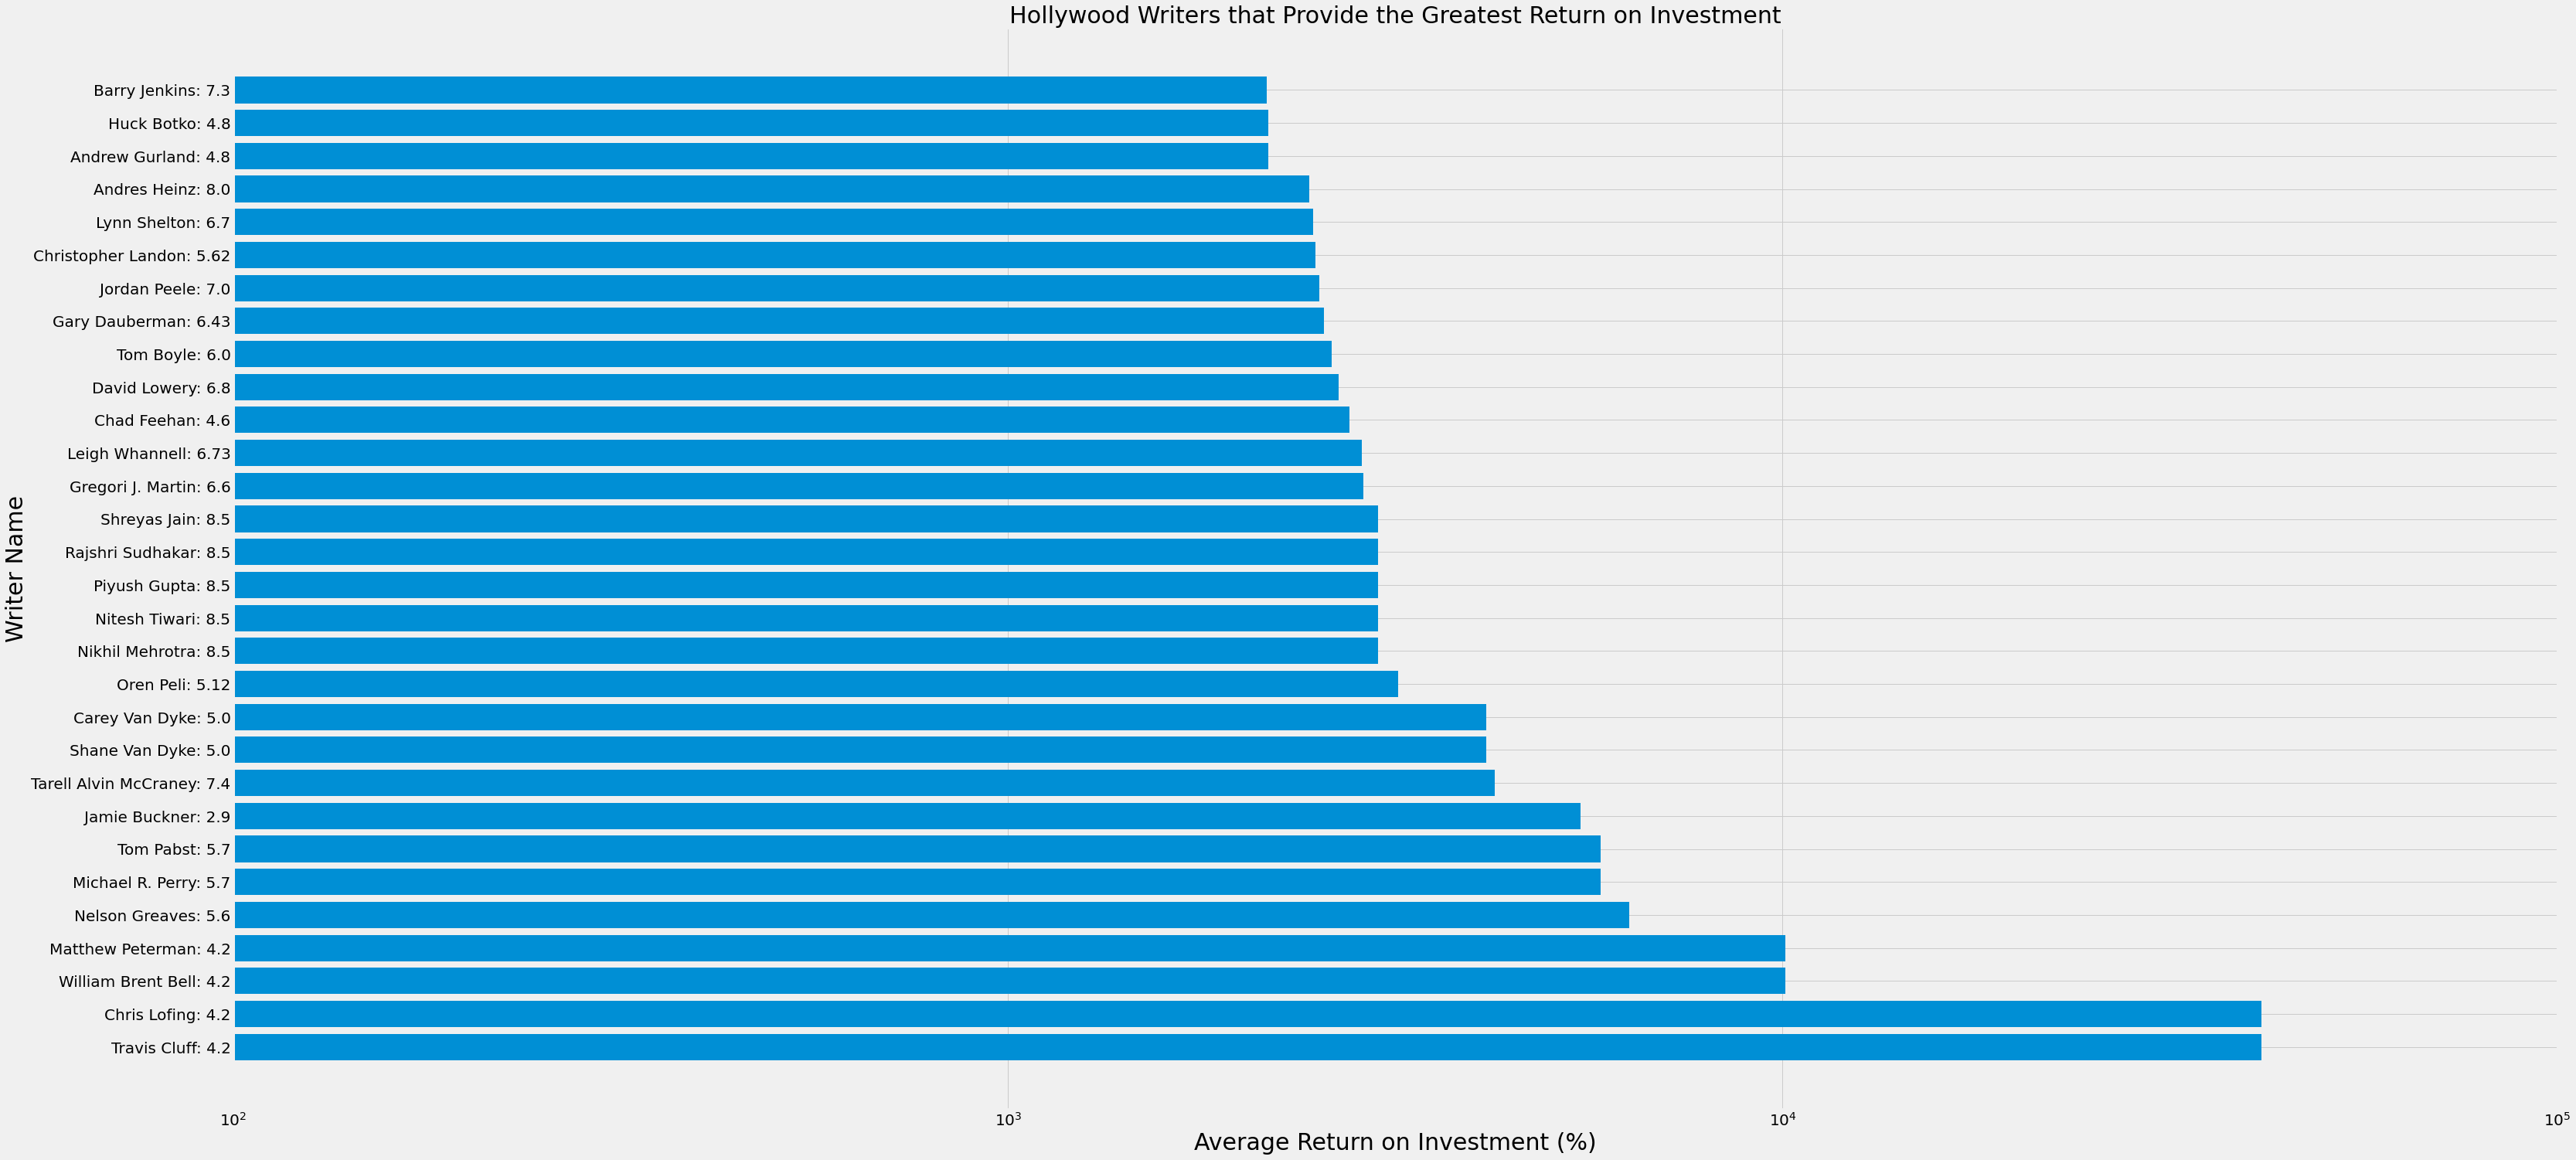

In [48]:
fig, ax = plt.subplots(figsize = (48,24))
x = wnames_wrating
y = writers_plot['ROI']
ax.barh(x,y)
ax.set_xscale('log')
ax.set_xticks([100, 1000, 10000,100000])
ax.set_xlabel('Average Return on Investment (%)', size = 30)
ax.set_title('Hollywood Writers that Provide the Greatest Return on Investment', size = 30)
ax.set_ylabel('Writer Name', size = 30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='y', which='minor', labelsize=20)
plt.style.use('fivethirtyeight');

# Mapping Fresh Score to 0/1 and Normalizing Rating Systems

In [11]:
joinedrt = rt_movies_df.set_index('id').join(rt_reviews_df, on = 'id', lsuffix = ' guidelines', rsuffix =' critical')
joinedrt = joinedrt.dropna(subset = ['runtime'])
joinedrt['freshnum'] = joinedrt['fresh'].map({'fresh': 1, 'rotten': 0})

The rating systems for different critics and their respective websites vary drastically. This can be anything from an A-F rating or a 0-100 rating with demicals. I normalized all of the ratings on a scale of 0-100 without decimals.

In [12]:
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'3/4' : 75, '4/5' : 80, '3/5' : 60, '1/4': 25, '1/5': 20,'3.5/4' : 87, '2/5': 40, '2/4': 50, '3.7/5': 74})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2.5/4': 63, '3.5/5' : 70, '5/5': 100, 'B': 85, '4/4': 100, 'B+': 88, "A-": 93, '2.5/5' : 50, "8/10" : 80, 'B-': 82, '4.5/5': 90, '1.5/4': 37.5, 'A': 95, '6/10': 60, 'C+': 77, '9/10': 90, "C": 74, 'C-': 72, '5/10': 50, '1.5/5': 30, '7/10': 70})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'0/5':0, '8': 80, '1': 10, '4/10': 40, 'D+': 69, '7': 70, '3/10': 30, 'D': 67, "0.5/4": 13, '6': 60}) 
joinedrt['rating critical'] = joinedrt['rating critical'].replace({"3": 30, "D-": 66, "1/10": 10, '0/4' : 0, '8.5/10': 85, "A+": 98, '4.0/4': 100, "8.4/10": 84, "9": 90, "F": 35, "7.5/10": 75, "7.7": 77, "2": 20, "0": 0, "2.0/5": 40, '0.5/10': 5}) 
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2/10': 20, '5.0/5': 100, '3.0/5': 60, "2.5": 50, '5': 50, '2.2/5': 44})

In [13]:
joinedrt['rating critical'].value_counts()

80.0     149
75.0     140
60.0     119
50.0      91
87.0      79
100.0     78
40.0      66
63.0      56
70.0      53
85.0      40
88.0      32
90.0      32
93.0      27
20.0      24
82.0      18
95.0      16
37.5      16
77.0      14
30.0      14
74.0      13
25.0      12
0.0       11
72.0      11
10.0       8
69.0       4
67.0       3
13.0       3
66.0       2
98.0       2
84.0       2
35.0       1
44.0       1
5.0        1
Name: rating critical, dtype: int64

# Studio Data Cleaning & Visualization

Next I took a look at the Studio Data and realized that the studios have many duplicate entities. For example, "20th Century Fox Distribution" shouldn't be counted as a different movie house than "20th Century Fox" because they are under the same umbrella. 

In [14]:
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures Classics':'Sony Pictures',  '20th Century Fox Distribution': '20th Century Fox','20th Century Fox Film Corporat': '20th Century Fox', 'A24': 'A24 Films', 'A24 and DIRECTV': 'A24 Films', 'Sony Pictures Releasing': 'Sony Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Lions Gate Films': "Lionsgate Films", 'Lionsgate': 'Lionsgate Films', "Paramount Vantage": "Paramount Pictures", 'Paramount Classics': "Paramount Pictures", "Paramount": 'Paramount Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures Home Entertainment':'Sony Pictures','Warner Bros. Pictures':'Warner Bros.', 'Universal Studios':'Universal Pictures','Sony Pictures Entertainment':'Sony Pictures','Sony Classics':'Sony Pictures', 'Paramount Home Video': 'Paramount Pictures', 'Universal':'Universal Pictures','Lions Gate':"Lionsgate Films",'Dreamworks/Paramount':'Paramount Pictures','Universal Pictures International':'Universal Pictures','Paramount Studios': 'Paramount Pictures'})                                       
joinedrt['studio'] = joinedrt['studio'].replace({'Lionsgate/Roadside Attractions': "Lionsgate Films", 'WARNER BROTHERS PICTURES': 'Warner Bros', 'Lions Gate Releasing':'Lionsgate Films','Twentieth Century Fox':'20th Century Fox','Fox International':'20th Century Fox','Lionsgate Films/After Dark Films':'Lionsgate Films', 'Universal Pictures Distributio':'Universal Pictures','Miramax':'Miramax Films'})
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures/Columbia':'Sony Pictures','IFC':'IFC Films','Sony Pictures/TriStar Pictures':'Sony Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Twentieth Century Fox Home Entertainment':'20th Century Fox','IFC First Take':'IFC Films','Lions Gate Films Inc.':'Lionsgate Films', 'WB':'Warner Bros.','Fox':'20th Century Fox','Warner Bros':'Warner Bros.','Walt Disney Animation Studios':'Walt Disney Pictures','Disneynature':'Walt Disney Pictures','Weinstein Company':'The Weinstein Company','The Weinstein Co.':'The Weinstein Company'})
joinedrt['studio'] = joinedrt['studio'].replace({'Weinstein Co.':'The Weinstein Company','Universal Studios Home Video':'Universal Pictures','United Artists Pictures/MGM':'MGM','Fox Searchlight':'Fox Searchlight Pictures','Sony Pictures/Columbia Pictures':'Columbia Pictures','Universal Studios Home Video':'Universal Pictures','New Line Home Entertainment':'New Line Cinema','Screen Gems/SONY PICTURES':'Sony Pictures','MGM/UA':'MGM','Buena Vista Distribution Compa':'Buena Vista Pictures'})


In [15]:
joinedrt['studio'].value_counts()

Sony Pictures                 47
Universal Pictures            41
Paramount Pictures            38
20th Century Fox              33
Warner Bros.                  32
                              ..
Mitropoulos Films              1
Freestyle Releasing            1
Orion Pictures Corporation     1
United Artists                 1
The Bigger Picture             1
Name: studio, Length: 148, dtype: int64

In [16]:
joinedrtstudio = joinedrt.sort_values('studio')
joinedrtstudiocleaned = joinedrtstudio.dropna(subset=['studio'])
joinedrtstudiocleaned2 = joinedrtstudiocleaned.groupby('studio').mean()
joinedrtstudiocleaned2['numberofmovies'] = joinedrt['studio'].value_counts()



In [17]:
toptenstudios = joinedrtstudiocleaned2.sort_values(by = 'numberofmovies', ascending = False)[:10]
toptenstudios = toptenstudios.reset_index()

Text(0.5, 1.0, 'Studios by Avg. Critical Rating')

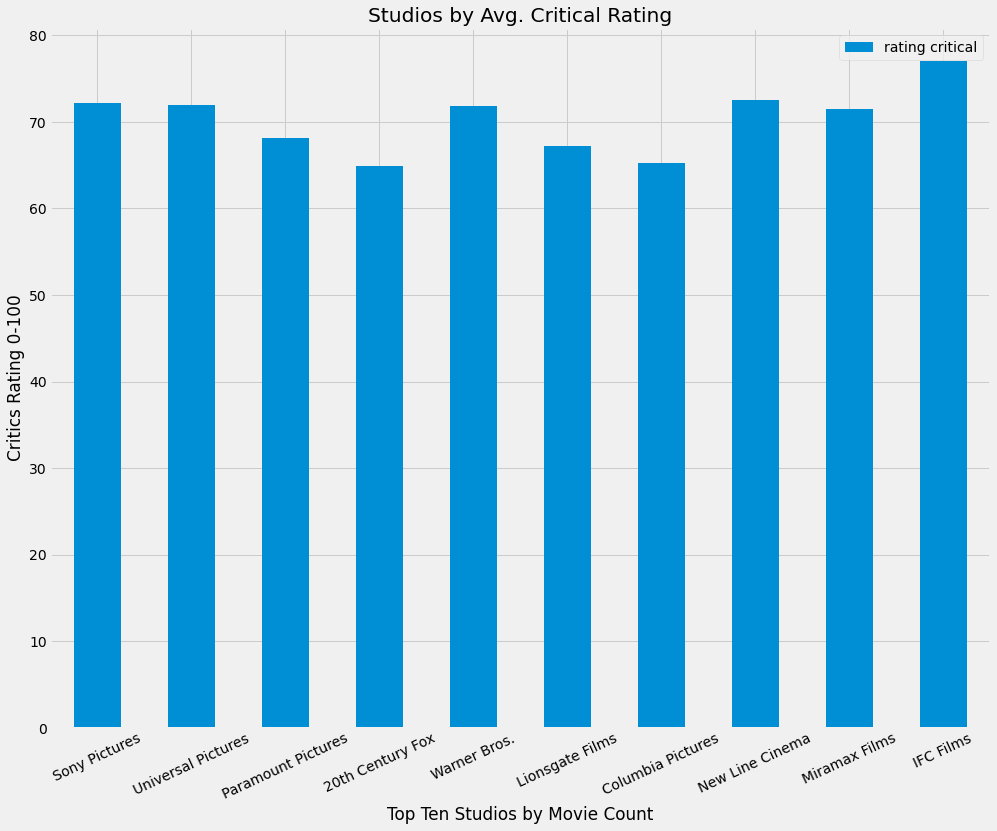

In [18]:
toptenstudios.plot('studio', 'rating critical', kind='bar', rot = 25, figsize = (15,12))

plt.xlabel('Top Ten Studios by Movie Count')
plt.ylabel('Critics Rating 0-100')
plt.title('Studios by Avg. Critical Rating')

In [19]:
# Merging IMDb dfs and dropping NaNs
imdb_basics_rating = pd.merge(left=imdb_basics_df,right=imdb_ratings_df,
                               on='tconst',how='inner')
imdb_basics_rating = imdb_basics_rating[imdb_basics_rating['genres'].isna() != True]

# Only interesting in movies with at 8 rating or above
imdb_ratings_over_8 = imdb_basics_rating[imdb_basics_rating['averagerating'] >= 8]

# Merging Rotten Tomatoes dfs and dropping NaNs
rt_reviews_df.dropna(inplace=True)
joinedrt_copy = joinedrt.copy()
joinedrt_copy = rt_movies_df.set_index('id').join(rt_reviews_df, on = 'id', lsuffix = ' guidelines', rsuffix =' critical')
joinedrt_copy = joinedrt_copy.dropna(subset = ['runtime'])

# Creating one unified measurement scale for the Rotten Tomatoes ratings column 
joinedrt_copy['freshnum'] = joinedrt_copy['fresh'].map({'fresh': 1, 'rotten': 0})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'3/4' : 75, '4/5' : 80, '3/5' : 60, '1/4': 25, '1/5': 20,'3.5/4' : 87, '2/5': 40, '2/4': 50, '3.7/5': 74})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'2.5/4': 63, '3.5/5' : 70, '5/5': 100, 'B': 85, '4/4': 100, 'B+': 88, "A-": 93, '2.5/5' : 50, "8/10" : 80, 'B-': 82, '4.5/5': 90, '1.5/4': 37.5, 'A': 95, '6/10': 60, 'C+': 77, '9/10': 90, "C": 74, 'C-': 72, '5/10': 50, '1.5/5': 30, '7/10': 70})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'0/5':0, '8': 80, '1': 10, '4/10': 40, 'D+': 69, '7': 70, '3/10': 30, 'D': 67, "0.5/4": 13, '6': 60}) 
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({"3": 30, "D-": 66, "1/10": 10, '0/4' : 0, '8.5/10': 85, "A+": 98, '4.0/4': 100, "8.4/10": 84, "9": 90, "F": 35, "7.5/10": 75, "7.7": 77, "2": 20, "0": 0, "2.0/5": 40, '0.5/10': 5}) 
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'2/10': 20, '5.0/5': 100, '3.0/5': 60, "2.5": 50, '5': 50, '2.2/5': 44})


joinedrt_copy['rating critical'] = joinedrt_copy['rating critical']/10

# Filtering movies with a rating of 8 or above
rt_ratings_over_8 = joinedrt_copy[joinedrt_copy['rating critical'] >= 8]

In [20]:
#Creating a list of all the Genres of the movies with an 8 rating or above for IMDb
genres = list(imdb_ratings_over_8['genres'])

genres_list = []

for genre in genres:
    List = str(genre).split(',')
    for individual_genre in List:
        genres_list.append(individual_genre)

# Creating a frequency dictionary for each genre
genre_frequency = {}
for element in genres_list:
    if element in genre_frequency:
        genre_frequency[element] += 1
    else:
        genre_frequency[element] = 1

# Sorted dictionary for IMDb
sorted_imdb_genres = {k: v for k, v in sorted(genre_frequency.items(), key=lambda item: item[1])}

# Same procedure to create a frequency for the Rotten Tomatoes movies
genres = list(rt_ratings_over_8['genre'])
genres_list_2 = []
for genre in genres:
    List = str(genre).split('|')
    for individual_genre in List:
        genres_list_2.append(individual_genre)
        
genre_frequency_2 = {}
for element in genres_list_2:
    if element in genre_frequency_2:
        genre_frequency_2[element] += 1
    else:
        genre_frequency_2[element] = 1
        
# Sorted dictionary for Rotten Tomatoes
sorted_rt_genres = {k: v for k, v in sorted(genre_frequency_2.items(), key=lambda item: item[1])}

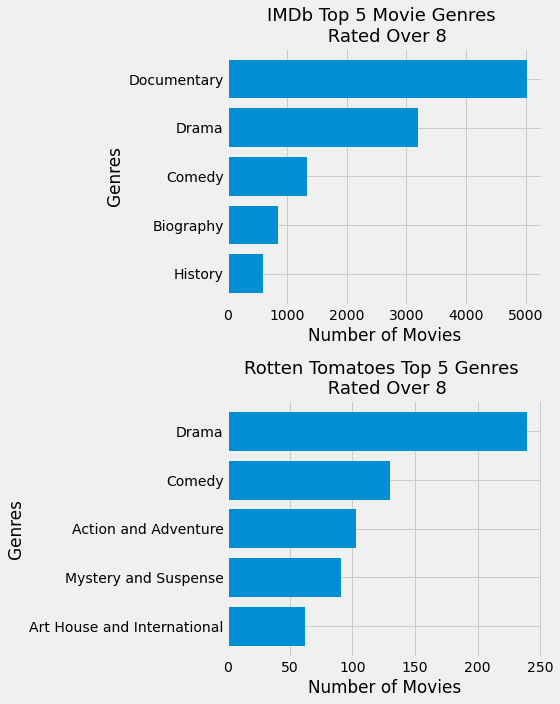

In [21]:
# Creating frequency chart for IMDb and Rotten Tomatoes movie genres with a rating of 8 or above
imdb_x = list(sorted_imdb_genres.keys())[20:]
imdb_y = list(sorted_imdb_genres.values())[20:]

rt_x = list(sorted_rt_genres.keys())[16:]
rt_y = list(sorted_rt_genres.values())[16:]

plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
plt.barh(imdb_x,imdb_y)
plt.title('IMDb Top 5 Movie Genres \n Rated Over 8', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Movies')
plt.ylabel('Genres')

plt.subplot(2,1,2)
plt.barh(rt_x,rt_y)
plt.title('Rotten Tomatoes Top 5 Genres \n Rated Over 8', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Movies')
plt.ylabel('Genres')

plt.tight_layout()
plt.show()

In [23]:
#table with the top 25 writers and their genres
genres = writers_profit.assign(genres = lambda x :writers_profit['genres'].str.split(',')).explode('genres')
writers_genre = genres.where(genres['ROI'] > 2491).groupby(['primary_name','genres']).mean('ROI').sort_values('averagerating', ascending = False)
top_writers_genre = writers_genre['averagerating']
top_writers_genre

primary_name        genres   
Nikhil Mehrotra     Drama        8.5
Piyush Gupta        Drama        8.5
Nitesh Tiwari       Drama        8.5
Piyush Gupta        Action       8.5
                    Biography    8.5
                                ... 
Travis Cluff        Thriller     4.2
William Brent Bell  Horror       4.2
Jamie Buckner       Sport        2.9
                    Romance      2.9
                    Comedy       2.9
Name: averagerating, Length: 93, dtype: float64

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

(zach)

There is no correlation between a director's average worldwide gross and average movie ratingfor the top 20 directors, but also for the entire dataset of directors. This gives us confidence that the results will generalize beyond the data in this analysis.

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

(zach)

There is no correlation between a director's average worldwide gross and average rating for their movies.
In order to compete with other studios by producing quality and successful movies we recommend that Microsoft specifically target directors that have exceeded in both. 